In [3]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


In [6]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Canny edge detection
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, 100, 200)
    img = Image.fromarray(edges)
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

In [8]:
train_dir = 'images_train_test_val/train'
validation_dir = 'images_train_test_val/validation'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [9]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Base Model

In [7]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 165s 702ms/step - accuracy: 0.0540 - loss: 3.1138 - val_accuracy: 0.0957 - val_loss: 2.9405
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 154s 664ms/step - accuracy: 0.1015 - loss: 2.9228 - val_accuracy: 0.2229 - val_loss: 2.5754
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 153s 659ms/step - accuracy: 0.2028 - loss: 2.5986 - val_accuracy: 0.2757 - val_loss: 2.3523
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 156s 671ms/step - accuracy: 0.2606 - loss: 2.3810 - val_accuracy: 0.3157 - val_loss: 2.2065
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 156s 671ms/step - accuracy: 0.3100 - loss: 2.1934 - val_accuracy: 0.3600 - val_loss: 2.0382
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 167s 718ms/step - accuracy: 0.3519 - loss: 2.0784 - val_accuracy: 0.3895 - val_loss: 1.9622
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 151s 650ms/step - accuracy: 0.3935 - loss: 1.9405 - val_accuracy: 0.4162 - val_loss: 1.8667
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 152s 652ms/step - accuracy: 0.4070 - loss: 1.89

In [8]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}')

230/230 ━━━━━━━━━━━━━━━━━━━━ 67s 291ms/step - accuracy: 0.5487 - loss: 1.4787
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.4442 - loss: 1.7362
Train accuracy: 0.5535, Validation accuracy: 0.4462


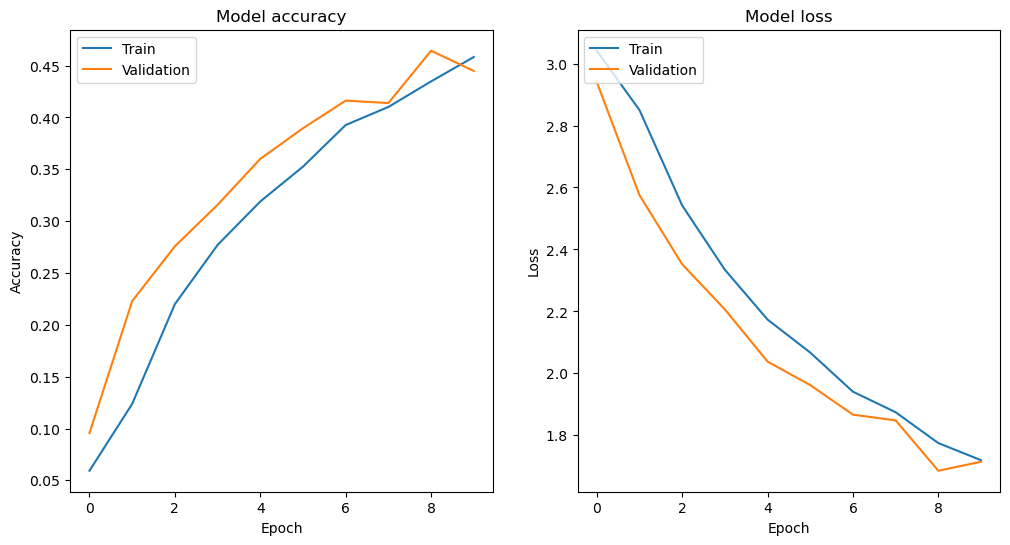

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Using Grid Search

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [48]:
train_dir = 'images_train_test_val/train'
validation_dir = 'images_train_test_val/validation'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [49]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [50]:
#create model
model = KerasClassifier(build_fn=create_model, verbose=0)

In [51]:
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'he_normal'],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

In [53]:
X_train, y_train = next(train_generator)
for _ in range(int(train_generator.samples / train_generator.batch_size) - 1):
    X, y = next(train_generator)
    X_train = np.vstack((X_train, X))
    y_train = np.vstack((y_train, y))


In [54]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

c:\Users\User\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When us

In [ ]:
# Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model(learning_rate=0.0001):
    base_model = ResNet50(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(21, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1)


In [ ]:
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)

random_search_result = random_search.fit(train_generator, validation_data=validation_generator)


In [ ]:
# Get the best parameters and results
best_params = random_search_result.best_params_
best_score = random_search_result.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

In [ ]:
# Using the best model for evaluation
best_model = random_search_result.best_estimator_.model
train_loss, train_acc = best_model.evaluate(train_generator)
val_loss, val_acc = best_model.evaluate(validation_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}')